<a href="https://colab.research.google.com/github/Ripa-Shah/Analyzing-Social-Sentiment-Data-to-determine-correlation-with-Cryptocurrency-Price/blob/main/MIS584_Cryptocurrency_sentimentdata_and_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
pip install pyspark praw nltk pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.6 MB/s eta 0:00:00


In [17]:
%pwd

'/content'

In [18]:
pip install tweepy praw requests pandas textblob vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [20]:
import praw
import pandas as pd
import time
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [22]:
# List of time filters to check, ordered from newest to oldest
TIME_FILTERS = ["day", "week", "month", "year"]

# Define the start date (as before)
start_date_str = "2025-08-15 00:00:00"
start_timestamp = datetime.strptime(start_date_str, "%Y-%m-%d %H:%M:%S").timestamp()

# Initialize a set to prevent processing the same post multiple times
processed_ids = set()

In [23]:
import praw
import pandas as pd
import time
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize Reddit API
reddit = praw.Reddit(
    client_id="M9iSExe3kRkwrILVO75-CA",
    client_secret="rnuYodBu7llgTAmssHujZVUt37mrAA",
    user_agent="crypto-sentiment-app by u/MindlessEssay2919"
)

# Define cryptocurrency keywords to track
crypto_keywords = {
    "bitcoin": "BTC",
    "btc": "BTC",
    "ethereum": "ETH",
    "eth": "ETH",
    "cardano": "ADA",
    "ada": "ADA",
    "dogecoin": "DOGE",
    "doge": "DOGE",
    "solana": "SOL",
    "sol": "SOL"
}

# CSV file path
CSV_FILE = "reddit_crypto_sentiment.csv"

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Initialize CSV file (only once)
df_init = pd.DataFrame(columns=[
    "date", "user_id", "type", "title", "cryptocurrency", "review", "sentiment_score"
])
df_init.to_csv(CSV_FILE, index=False)

print("🔄 Starting Reddit post & comment sentiment streaming...")

# ----------------------------------------------------------------------
# NEW FETCHING LOGIC
# ----------------------------------------------------------------------

records = []
print(f"Fetching posts since {start_date_str}...")

# 1. Iterate over the time filters
for time_filter in TIME_FILTERS:
    print(f"\n--- Checking Top posts for: {time_filter.upper()} ---")

    # Fetch the top posts for the current time filter (max 1000 per request)
    # The 'limit=None' tells PRAW to fetch up to its internal limit (usually 1000)
    for post in reddit.subreddit("CryptoCurrency").top(time_filter=time_filter, limit=None):
        post_timestamp = post.created_utc

        # Check 1: Has this post been processed already? (Prevents duplicates from different time filters)
        if post.id in processed_ids:
            continue

        # Check 2: Is the post within the required August 1st to Today range?
        if post_timestamp >= start_timestamp:

            # Mark the post as processed
            processed_ids.add(post.id)

            # --- Start Existing Processing Logic (Post) ---
            title = post.title
            review = post.selftext if post.selftext else ""
            user_id = str(post.author) if post.author else "Anonymous"
            date = datetime.utcfromtimestamp(post_timestamp).strftime("%Y-%m-%d %H:%M:%S")

            # Detect which crypto is mentioned
            text_lower = (title + " " + review).lower()
            found_coin = None
            # ... (Rest of your crypto keyword detection logic)
            for keyword, symbol in crypto_keywords.items():
                if keyword in text_lower:
                    found_coin = symbol
                    break
            if not found_coin:
                continue

            # Sentiment for post
            sentiment = analyzer.polarity_scores(title + " " + review)["compound"]
            records.append([date, user_id, "post", title, found_coin, review, sentiment])
            print(f"✅ Found Post ({time_filter}): {date} | {found_coin} | Sentiment: {sentiment:+.3f}")

            # --- Start Existing Comment Processing Logic ---
            post.comments.replace_more(limit=0)
            for comment in post.comments.list()[:10]:
                # ... (Your existing comment processing and sentiment logic goes here)
                comment_text = comment.body
                comment_user = str(comment.author) if comment.author else "Anonymous"
                comment_date = datetime.utcfromtimestamp(comment.created_utc).strftime("%Y-%m-%d %H:%M:%S")

                if not comment_text or comment_text in ["[deleted]", "[removed]"]:
                    continue

                comment_lower = comment_text.lower()
                comment_coin = found_coin
                for keyword, symbol in crypto_keywords.items():
                    if keyword in comment_lower:
                        comment_coin = symbol
                        break

                comment_sent = analyzer.polarity_scores(comment_text)["compound"]
                records.append([comment_date, comment_user, "comment", title, comment_coin, comment_text, comment_sent])

        elif time_filter == "year" and post_timestamp < start_timestamp:
            # Only break out of the loop if we're on the longest time filter and found old data.
            # Shorter filters ("day", "week") will naturally stop finding posts as they go too far back.
            print(f"--- Stopping fetch: Hit post older than {start_date_str} on the 'year' filter. ---")
            break

# ----------------------------------------------------------------------
# END NEW FETCHING LOGIC
# ----------------------------------------------------------------------

# --- Final Saving Logic (Run once after all fetching is complete) ---
if records:
    df = pd.DataFrame(records, columns=["date", "user_id", "type", "title", "cryptocurrency", "review", "sentiment_score"])
    df.to_csv(CSV_FILE, mode="a", header=False, index=False)
    print(f"\n✅ FINAL SAVE: Collected and saved {len(records)} unique entries to {CSV_FILE}")

print("Processing complete.")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



🔄 Starting Reddit post & comment sentiment streaming...
Fetching posts since 2025-08-15 00:00:00...

--- Checking Top posts for: DAY ---


/tmp/ipython-input-2245392545.py:72: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date = datetime.utcfromtimestamp(post_timestamp).strftime("%Y-%m-%d %H:%M:%S")
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (day): 2025-11-15 04:51:36 | BTC | Sentiment: -0.296


/tmp/ipython-input-2245392545.py:96: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  comment_date = datetime.utcfromtimestamp(comment.created_utc).strftime("%Y-%m-%d %H:%M:%S")
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (day): 2025-11-15 07:33:39 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (day): 2025-11-15 02:50:11 | ETH | Sentiment: +0.000
✅ Found Post (day): 2025-11-15 07:45:47 | BTC | Sentiment: -0.186


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (day): 2025-11-15 17:58:58 | BTC | Sentiment: +0.000
✅ Found Post (day): 2025-11-15 10:47:26 | BTC | Sentiment: -0.681


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (day): 2025-11-15 17:00:00 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (day): 2025-11-15 01:00:46 | ETH | Sentiment: +0.954


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (day): 2025-11-15 19:52:48 | ETH | Sentiment: +0.202
✅ Found Post (day): 2025-11-15 10:31:26 | ETH | Sentiment: +0.743


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (day): 2025-11-15 17:13:26 | ETH | Sentiment: +0.981
✅ Found Post (day): 2025-11-15 06:06:59 | ETH | Sentiment: +0.976


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (day): 2025-11-15 08:14:56 | BTC | Sentiment: +0.949

--- Checking Top posts for: WEEK ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 12:15:45 | BTC | Sentiment: -0.421


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 18:48:54 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 19:21:29 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 18:46:04 | BTC | Sentiment: -0.991


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 19:28:23 | BTC | Sentiment: -0.340


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 20:08:29 | BTC | Sentiment: -0.670


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 13:32:41 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 15:40:20 | BTC | Sentiment: +0.872


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 07:08:34 | BTC | Sentiment: -0.318


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 17:06:34 | BTC | Sentiment: -0.421


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 15:14:36 | BTC | Sentiment: +0.219


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 15:36:32 | BTC | Sentiment: +0.226


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 18:57:30 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 15:59:05 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 15:19:49 | ETH | Sentiment: +0.401


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 21:44:28 | BTC | Sentiment: -0.052


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 08:20:15 | ETH | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 17:57:07 | BTC | Sentiment: -0.296


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 19:27:43 | BTC | Sentiment: -0.712


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 04:45:59 | BTC | Sentiment: +0.153
✅ Found Post (week): 2025-11-13 16:20:23 | BTC | Sentiment: +0.542


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 16:20:59 | BTC | Sentiment: -0.477


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 20:37:29 | BTC | Sentiment: -0.516


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 14:21:36 | BTC | Sentiment: +0.000
✅ Found Post (week): 2025-11-13 22:04:01 | BTC | Sentiment: +0.956


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 10:31:10 | BTC | Sentiment: +0.000
✅ Found Post (week): 2025-11-10 07:41:42 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 07:10:17 | BTC | Sentiment: -0.103


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 12:55:28 | ETH | Sentiment: +0.402


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 10:00:52 | ETH | Sentiment: +0.000
✅ Found Post (week): 2025-11-09 21:34:49 | BTC | Sentiment: +0.118


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 20:53:26 | ETH | Sentiment: +0.000
✅ Found Post (week): 2025-11-13 19:20:47 | BTC | Sentiment: +0.202


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 17:38:58 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 15:05:32 | ETH | Sentiment: +0.945


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 17:20:18 | BTC | Sentiment: +0.000
✅ Found Post (week): 2025-11-12 19:16:17 | ETH | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 18:46:46 | BTC | Sentiment: -0.541
✅ Found Post (week): 2025-11-10 02:14:47 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 05:29:01 | BTC | Sentiment: -0.026


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 08:48:46 | BTC | Sentiment: -0.318


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-08 22:29:09 | BTC | Sentiment: +1.000
✅ Found Post (week): 2025-11-12 20:54:36 | BTC | Sentiment: -0.128


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 16:31:37 | BTC | Sentiment: +0.984


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 01:00:39 | ETH | Sentiment: +0.954


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 16:58:43 | BTC | Sentiment: +0.000
✅ Found Post (week): 2025-11-09 03:40:33 | BTC | Sentiment: -0.656


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 07:48:38 | BTC | Sentiment: +0.000
✅ Found Post (week): 2025-11-11 11:55:09 | ETH | Sentiment: +0.989


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 07:31:54 | BTC | Sentiment: +0.421
✅ Found Post (week): 2025-11-11 01:00:50 | ETH | Sentiment: +0.954


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 21:19:31 | ETH | Sentiment: +0.999


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 01:01:06 | ETH | Sentiment: +0.954


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 01:00:55 | ETH | Sentiment: +0.954


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 14:44:20 | BTC | Sentiment: +0.097
✅ Found Post (week): 2025-11-10 17:38:03 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 01:00:47 | ETH | Sentiment: +0.954


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 19:12:56 | ETH | Sentiment: +0.947


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 14:19:40 | BTC | Sentiment: +0.440
✅ Found Post (week): 2025-11-12 19:19:53 | BTC | Sentiment: -0.840


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 20:59:06 | ADA | Sentiment: +0.000
✅ Found Post (week): 2025-11-09 14:52:31 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 01:00:48 | ETH | Sentiment: +0.954


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 16:12:37 | ETH | Sentiment: +0.000
✅ Found Post (week): 2025-11-11 15:04:40 | BTC | Sentiment: +0.854


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 01:25:19 | ETH | Sentiment: +1.000
✅ Found Post (week): 2025-11-13 00:24:44 | ETH | Sentiment: +0.765


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 18:21:23 | ETH | Sentiment: +0.318
✅ Found Post (week): 2025-11-11 21:34:47 | BTC | Sentiment: -0.727


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 08:45:35 | BTC | Sentiment: +0.929


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 18:31:54 | ETH | Sentiment: +0.968
✅ Found Post (week): 2025-11-11 08:09:06 | BTC | Sentiment: +0.599


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 18:04:07 | BTC | Sentiment: +0.000
✅ Found Post (week): 2025-11-12 19:14:22 | BTC | Sentiment: -0.446


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 15:53:52 | ETH | Sentiment: +0.420
✅ Found Post (week): 2025-11-14 20:02:44 | ETH | Sentiment: +0.788


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 07:53:12 | BTC | Sentiment: +0.000
✅ Found Post (week): 2025-11-14 06:31:54 | ETH | Sentiment: -0.077


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 20:48:05 | SOL | Sentiment: -0.178
✅ Found Post (week): 2025-11-09 09:46:22 | BTC | Sentiment: +0.821


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 20:48:25 | ETH | Sentiment: -0.572
✅ Found Post (week): 2025-11-12 11:53:21 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 10:04:11 | ETH | Sentiment: +0.833


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 20:37:36 | ETH | Sentiment: +0.026
✅ Found Post (week): 2025-11-11 08:21:14 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 11:24:47 | ETH | Sentiment: +0.723


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 08:49:19 | BTC | Sentiment: +0.000
✅ Found Post (week): 2025-11-09 03:16:45 | BTC | Sentiment: +0.026


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-14 16:29:24 | BTC | Sentiment: +0.975


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 16:16:24 | ADA | Sentiment: +0.884
✅ Found Post (week): 2025-11-14 21:43:38 | ETH | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-11 15:15:18 | BTC | Sentiment: +0.000
✅ Found Post (week): 2025-11-11 04:52:32 | ETH | Sentiment: +0.998


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-09 18:30:50 | ETH | Sentiment: +0.318
✅ Found Post (week): 2025-11-13 19:59:54 | BTC | Sentiment: -0.103


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 14:54:15 | ETH | Sentiment: +0.000
✅ Found Post (week): 2025-11-12 08:30:45 | ETH | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-10 14:56:04 | BTC | Sentiment: +0.492
✅ Found Post (week): 2025-11-09 08:23:10 | SOL | Sentiment: +0.949


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 18:19:36 | BTC | Sentiment: +0.867
✅ Found Post (week): 2025-11-10 15:33:30 | BTC | Sentiment: +0.999


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-13 20:25:00 | BTC | Sentiment: +0.445
✅ Found Post (week): 2025-11-13 11:56:45 | ETH | Sentiment: -0.928


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (week): 2025-11-12 18:52:12 | BTC | Sentiment: +0.361

--- Checking Top posts for: MONTH ---


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-31 21:39:48 | BTC | Sentiment: +0.996


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-28 16:31:02 | BTC | Sentiment: +0.361


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-07 17:39:54 | BTC | Sentiment: +0.532


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-07 11:14:05 | ETH | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-25 18:16:55 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-06 08:17:16 | BTC | Sentiment: -0.542


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-26 15:24:54 | BTC | Sentiment: +0.226


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-19 18:54:34 | SOL | Sentiment: -0.988


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-21 20:50:07 | BTC | Sentiment: -0.402


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-28 00:41:42 | BTC | Sentiment: +0.202


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-19 17:38:37 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-29 11:28:08 | SOL | Sentiment: -0.948


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-04 21:19:34 | BTC | Sentiment: -0.813


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-04 09:44:13 | BTC | Sentiment: +0.812


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-17 15:58:19 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-07 22:12:55 | BTC | Sentiment: +0.331


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-05 17:46:52 | BTC | Sentiment: -0.103


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-30 15:05:36 | BTC | Sentiment: -0.296


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-23 13:15:01 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-05 01:04:34 | BTC | Sentiment: +0.537


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-01 19:27:22 | BTC | Sentiment: -0.660


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-31 08:56:42 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-27 20:00:00 | BTC | Sentiment: +0.226


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-04 08:02:34 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-21 22:08:36 | BTC | Sentiment: +0.103


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-04 03:09:22 | BTC | Sentiment: -0.402


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-04 19:05:20 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-01 19:10:04 | ETH | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-24 07:56:34 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-04 16:32:04 | BTC | Sentiment: -0.855


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-26 13:48:45 | ETH | Sentiment: +0.866


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-07 17:51:16 | BTC | Sentiment: -0.477


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-21 05:21:18 | BTC | Sentiment: -0.527


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-27 13:31:27 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-20 17:02:23 | BTC | Sentiment: +0.226


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-06 15:29:05 | BTC | Sentiment: +0.202


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-20 06:52:50 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-03 16:48:08 | BTC | Sentiment: +0.202


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-26 21:07:30 | ETH | Sentiment: +0.972


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-19 11:31:19 | BTC | Sentiment: -0.988


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-17 09:00:02 | BTC | Sentiment: -0.907


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-19 02:46:19 | ETH | Sentiment: +0.361


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-04 17:40:01 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-06 13:55:35 | BTC | Sentiment: -0.612


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-30 15:17:38 | BTC | Sentiment: -0.494


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-08 14:41:18 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-01 08:01:54 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-28 16:52:30 | BTC | Sentiment: +0.964


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-17 16:49:00 | BTC | Sentiment: -0.625


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-30 09:28:53 | BTC | Sentiment: -0.406


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-02 17:46:20 | BTC | Sentiment: +0.273


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-05 09:07:50 | BTC | Sentiment: -0.710


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-02 00:01:48 | ETH | Sentiment: +0.440


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-26 11:33:03 | ETH | Sentiment: +0.441


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-29 20:31:04 | BTC | Sentiment: -0.477


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-29 18:49:39 | BTC | Sentiment: +0.382


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-22 03:04:15 | BTC | Sentiment: -0.542


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-08 21:51:22 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-03 17:33:03 | BTC | Sentiment: -0.986


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-30 12:17:15 | BTC | Sentiment: -0.527


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-31 16:08:22 | ETH | Sentiment: +0.973


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-04 20:42:29 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-18 23:02:38 | BTC | Sentiment: +0.891


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-30 14:50:52 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-17 09:11:43 | BTC | Sentiment: -0.494


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-25 03:48:24 | BTC | Sentiment: -0.700


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-28 14:54:59 | SOL | Sentiment: +0.996


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-19 16:25:20 | BTC | Sentiment: +0.226
✅ Found Post (month): 2025-10-20 22:22:54 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-26 21:41:47 | ETH | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-25 16:11:32 | BTC | Sentiment: +0.572


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-24 05:50:48 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-27 20:22:56 | BTC | Sentiment: +0.527


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-24 17:53:02 | BTC | Sentiment: +0.440


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-19 10:00:33 | ETH | Sentiment: +0.103
✅ Found Post (month): 2025-10-18 19:35:42 | BTC | Sentiment: -0.273


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-03 21:20:36 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-19 00:35:22 | ADA | Sentiment: -0.954


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-17 10:19:42 | BTC | Sentiment: -0.808


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-26 13:36:02 | BTC | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-10-25 01:47:13 | ETH | Sentiment: +0.981


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



✅ Found Post (month): 2025-11-04 07:57:52 | ETH | Sentiment: +0.000


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




--- Checking Top posts for: YEAR ---
--- Stopping fetch: Hit post older than 2025-08-15 00:00:00 on the 'year' filter. ---

✅ FINAL SAVE: Collected and saved 1882 unique entries to reddit_crypto_sentiment.csv
Processing complete.


In [1]:
!pip install pyspark

In [2]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("MIS584_Spark_Basics")
sc = SparkContext(conf = conf)

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MIS584_Spark_Basics").getOrCreate()

In [4]:

# you can get a spark context from a spark session
sc = spark.sparkContext

In [ ]:
#download the dataset crypto_prices_historical.csv and reddit_crypto_Sentiment.csv

In [31]:
# create a spark dataframe from a pandas dataframe
import pandas as pd

## first, read the external csv file into a pandas dataframe
crypto_prices = pd.read_csv('crypto_prices_historical.csv')

## then, convert the pandas dataframe to a spark dataframe
df = spark.createDataFrame(crypto_prices)
df.show(n=10)

## we can also convert a spark dataframe to a pandas dataframe
pdf = df.toPandas()
print(pdf.head(20))

+---------------+-------+-----------+
|      timestamp| symbol|      price|
+---------------+-------+-----------+
|8/15/2025 17:00|BTC-USD|117678.0078|
|8/15/2025 18:00|BTC-USD|117189.3281|
|8/15/2025 19:00|BTC-USD|117005.4922|
|8/15/2025 20:00|BTC-USD|117355.7578|
|8/15/2025 21:00|BTC-USD|117377.7891|
|8/15/2025 22:00|BTC-USD|117777.8281|
|8/15/2025 23:00|BTC-USD|117416.2891|
| 8/16/2025 0:00|BTC-USD|117834.2734|
| 8/16/2025 1:00|BTC-USD|117899.3203|
| 8/16/2025 2:00|BTC-USD| 117597.875|
+---------------+-------+-----------+
only showing top 10 rows

          timestamp   symbol        price
0   8/15/2025 17:00  BTC-USD  117678.0078
1   8/15/2025 18:00  BTC-USD  117189.3281
2   8/15/2025 19:00  BTC-USD  117005.4922
3   8/15/2025 20:00  BTC-USD  117355.7578
4   8/15/2025 21:00  BTC-USD  117377.7891
5   8/15/2025 22:00  BTC-USD  117777.8281
6   8/15/2025 23:00  BTC-USD  117416.2891
7    8/16/2025 0:00  BTC-USD  117834.2734
8    8/16/2025 1:00  BTC-USD  117899.3203
9    8/16/2025 2:00  B

In [34]:
# create a spark dataframe from a pandas dataframe
import pandas as pd

## first, read the external csv file into a pandas dataframe
df_reddit_crypto = pd.read_csv('reddit_crypto_sentiment.csv')

## then, convert the pandas dataframe to a spark dataframe
df_reddit_crypto = spark.createDataFrame(pdf)
df_reddit_crypto.show(n=5)

## we can also convert a spark dataframe to a pandas dataframe
pdf_reddit = df_reddit_crypto.toPandas()
print(pdf_reddit.head(20))

+-------------------+-----------------+-------+--------------------+--------------+--------------------+---------------+
|               date|          user_id|   type|               title|cryptocurrency|              review|sentiment_score|
+-------------------+-----------------+-------+--------------------+--------------+--------------------+---------------+
|2025-11-15 04:51:36|       GreedVault|   post|Jeffrey Epstein W...|           BTC|                 NaN|         -0.296|
|2025-11-15 04:51:37|    AutoModerator|comment|Jeffrey Epstein W...|           BTC|It looks like thi...|         0.9063|
|2025-11-15 08:41:41|Large-Example1665|comment|Jeffrey Epstein W...|           BTC|He should have wo...|        -0.7579|
|2025-11-15 05:00:15|    coinfeeds-bot|comment|Jeffrey Epstein W...|           BTC|tldr; Jeffrey Eps...|         0.8979|
|2025-11-15 09:33:02|  Clear_Hawk_6187|comment|Jeffrey Epstein W...|           BTC|Do we know his Re...|         0.6124|
+-------------------+-----------

In [35]:
from pyspark.sql.types import *

# create a spark dataframe from a csv file with inferred schema:
df_reddit_crypto = spark.read.csv('reddit_crypto_sentiment.csv', header=True, inferSchema=True) # Spark will automatically detect the data type of each column.
df_reddit_crypto.show()

# print the schema (column names and types of a dataframe)
print('Inferred Schema of the DataFrame:')
df_reddit_crypto.printSchema()

# create a spark dataframe from a csv file with specified schema:
schema = StructType([
    StructField('date', TimestampType(), True),
    StructField('user_id', StringType(), True),
    StructField('tyoe', StringType(), True),
    StructField('title', StringType(), True),
    StructField('cryptocurrency', StringType(), True),
    StructField('review',StringType(),True),
    StructField('sentiment_score',DoubleType(),True)
])
df_reddit_crypto = spark.read.csv('reddit_crypto_sentiment.csv', header=True, schema=schema)
print('Specified Schema of the DataFrame:')
df_reddit_crypto.printSchema()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|                date|             user_id|                type|               title|      cryptocurrency|              review|sentiment_score|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+
| 2025-11-15 04:51:36|          GreedVault|                post|Jeffrey Epstein W...|                 BTC|                NULL|         -0.296|
| 2025-11-15 04:51:37|       AutoModerator|             comment|Jeffrey Epstein W...|                 BTC|It looks like thi...|           NULL|
|Please note that ...|             suggest|            advocate|     instruct others| or ask for help ...|                NULL|           NULL|
|Note:  Tax discus...|                NULL|                NULL|                NULL|                NULL|                NULL|         

In [36]:
# get the number of rows for a dataframe
print()
print('Number of rows of the DataFrame:', df_reddit_crypto.count())

# get the number of columns and column ames for a dataframe
print()
print('Number of columns of the DataFrame:', len(df_reddit_crypto.columns))
print('Column names of the DataFrame:', df_reddit_crypto.columns)


Number of rows of the DataFrame: 3452

Number of columns of the DataFrame: 7
Column names of the DataFrame: ['date', 'user_id', 'tyoe', 'title', 'cryptocurrency', 'review', 'sentiment_score']


In [37]:
# drop duplicates from a dataframe
print('Number of rows before dropping duplicates:', df_reddit_crypto.count())
df_reddit_crypto.dropDuplicates().count()
print('Number of rows after dropping duplicates:', df_reddit_crypto.dropDuplicates().count())

Number of rows before dropping duplicates: 3452
Number of rows after dropping duplicates: 2702


In [42]:
pdf_reddit = df_reddit_crypto.toPandas()

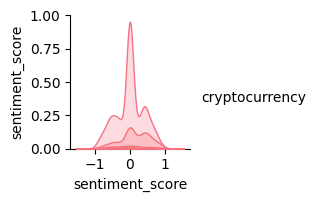

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(pdf_reddit[['title', 'review', 'sentiment_score', 'cryptocurrency']], hue='cryptocurrency', height=2)
plt.show()